# Intro

안녕하세요! 빠르고 더러운 커널은 Keras를 사용해서 어떻게 핵을 segmentation하는지 시작하는 방법을 보여줍니다.<br>
Hello! This rather quick and dirty kernel shows how to get started on segmenting nuclei using a neural network in Keras.

'U-Net'이라는 구조를 사용하였고, 'U-Net'은 이미지 segmentation 분야에서 가장 유명합니다. 작은 데이터 셋에서도 잘 동작하는 구조라고 생각합니다.<br>
이번 Kernel에서는 'U-Net'을 사용해서 구현을 하였지만 제가 번역을 하면서 다른 network 구조를 사용하면 더 좋은 결과를 얻을 수 있지 않을까 하여 'DeepLabv3+' 구조를 사용하였습니다.
The architecture used is the so-called U-Net, which is very common for image segmentation problems such as this. I believe they also have a tendency to work quite well even on small datasets.

필요한 모든 것을 가져옵시다!<br>
Let's get started importing everything we need!

In [8]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = './input/stage1_train/'
TEST_PATH = './input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [9]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get the data

 첫 번째로 이미지와 관련된 마스크를 가져와봅시다. training images와 test images를 관리하기 쉽고 가볍게 하기 위해서 다운 샘플링하지만 우리는 정확한 run-length encodings을 생성하고 predicted masks를 upsample하기 위해서 test images의 원래 사이즈를 기록해둬야한다.<br>
 Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now! 

In [10]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [02:05<00:00,  5.35it/s]


Getting and resizing test images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 65.07it/s]


Done!


불러온 데이터의 images와 masks의 그림으로 확인해봅시다.<br>
Let's see if things look all right by drawing some random images and their associated masks.

C:\Users\myeongjun\Anaconda3\envs\Python\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\myeongjun\Anaconda3\envs\Python\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


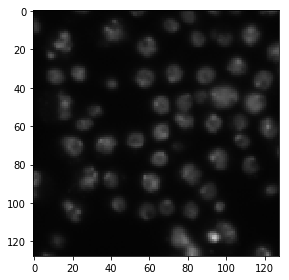

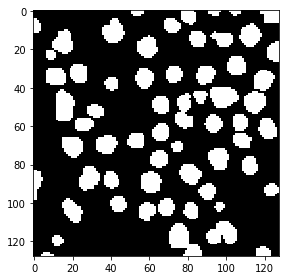

In [6]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

# Create our Keras metric

이제 mean average precision을 정의하기 위해서 Keras에 있는 intersection over union(IoU)를 이용할 것입니다. 이미 Tensorflow에서 IoU metric을 지원하지만 tensorflow에서 제공하는 것은 여러 thresholds에 대한 기능은 지원하지 않습니다. 따라서 저는 그것을 구현해서 사용하였습니다.<br>
현재 구현한 것이 정확하다고는 말 못하겠습니다. 어떠한 도움도 환영입니다.<br>
Now we try to define the mean average precision at different intersection over union (IoU) thresholds metric in Keras. TensorFlow has a mean IoU metric, but it doesn't have any native support for the mean over multiple thresholds, so I tried to implement this. I'm by no means certain that this implementation is correct, though! Any assistance in verifying this would be most welcome!

업데이트: 구현한 코드는 여기서 확인되는 결과와 LeaderBoard 결과 간 차이가 너무 크기 때문에 정확하지 않습니다. 그것은 아무리 training해도 증가하는 것 처럼 보일 것입니다.<br>
Update: This implementation is most definitely not correct due to the very large discrepancy between the results reported here and the LB results. It also seems to just increase over time no matter what when you train ...

In [11]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Build and train our neural network

다음으로 DeepLabv3+의 network architecture를 만들도록 하겠습니다. DeepLabv3+는 현재 State-of-the-art의 성능을 보이고 있으며 2018 ECCV에 publish되었습니다.